# Linear Leios DeltaQ analysis

*Linear Leios* is a protocol extending *Ouroboros Praos* to increase throughput. The protocol is specified in __[CIP0164](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164)__ and documented in __[Ouroborus Leios](https://leios.cardano-scaling.org/)__. 

The DeltaQ analysis of *Linear Leios* is based on
* __[Supporting information for modeling Linear Leios](https://github.com/input-output-hk/ouroboros-leios/blob/main/analysis/deltaq/linear-leios-preliminaries.md)__

and the analysis of *Ouroboros Praos*, see
* __[Mind Your Outcomes: Quality-Centric Systems Development, 2022](https://iohk.io/en/research/library/papers/mind-your-outcomes-the-dqsd-paradigm-for-quality-centric-systems-development-and-its-application-to-a-blockchain-case-study/)__
* __[Modelling Block Diffusion in Cardano using âˆ†Q](https://github.com/IntersectMBO/cardano-formal-specifications/tree/main/src/performance/)__

In [1]:
{-# LANGUAGE FlexibleContexts #-}
{-# LANGUAGE GADTs #-}

import Data.Ratio
import Text.Printf

import DeltaQ

import Graphics.Rendering.Chart.Backend.Cairo
import Graphics.Rendering.Chart.Easy
import Graphics.Rendering.Chart.Renderable

import Statistics.Distribution
import Statistics.Distribution.Exponential
import Statistics.Distribution.Gamma
import Statistics.Distribution.Lognormal

# Linear Leios

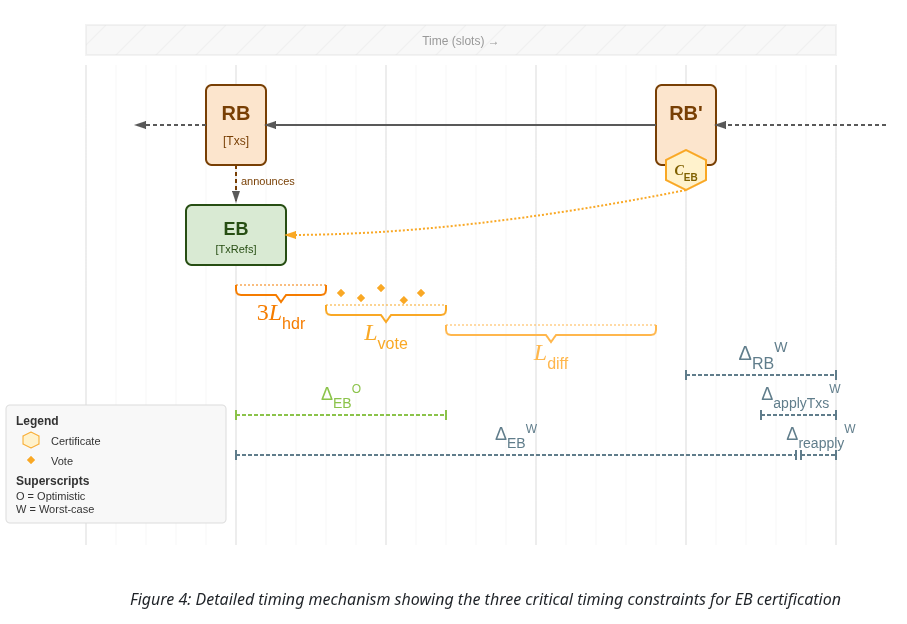

Feasible Parameters as mentioned in the CIP: 

In [2]:
lHdr  = 1
lVote = 4
lDiff = 7

In [3]:
waitingSlots = 3*lHdr + lVote + lDiff

In [4]:
slotLength = 1

## RB diffusion

Block diffusion copied from Praos. TODO: Use results from topology checker tool instead

In [5]:
data BlockSize = B64 | B256 | B512 | B1024 | B2048
    deriving (Show, Eq)
    
blockSizes :: [BlockSize]
blockSizes = [B64, B256, B512, B1024, B2048]

In [6]:
short :: BlockSize -> DQ
short B64     = wait 0.024
short B256    = wait 0.047
short B512    = wait 0.066
short B1024   = wait 0.078
short B2048   = wait 0.085

In [7]:
medium :: BlockSize -> DQ
medium B64    = wait 0.143
medium B256   = wait 0.271
medium B512   = wait 0.332
medium B1024  = wait 0.404
medium B2048  = wait 0.469

In [8]:
long :: BlockSize -> DQ
long B64      = wait 0.531
long B256     = wait 1.067
long B512     = wait 1.598
long B1024    = wait 1.598
long B2048    = wait 1.867

In [9]:
hop :: BlockSize -> DQ
hop b = choices [(1, short b), (1, medium b), (1, long b)]

In [10]:
doSequentially :: [DQ] -> DQ
doSequentially = foldr (.>>.) (wait 0)

In [11]:
hops :: Int -> BlockSize -> DQ
hops n b = doSequentially (replicate n (hop b))

### Block diffusion

Active slot coefficient, i.e. the rate of block production

In [12]:
lambda = 0.05

In [13]:
praosBlockDistr :: ExponentialDistribution
praosBlockDistr = exponential lambda

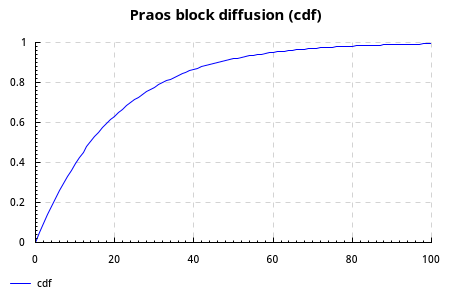

In [14]:
toRenderable $ 
    let xs = [0..100]
        vs = [(x, cumulative praosBlockDistr x) | x <- xs]
    in do 
        layout_title .= "Praos block diffusion (cdf)"
        plot (line "cdf" [vs])

In [15]:
blockProb = cumulative praosBlockDistr waitingSlots
printf "Probability that the next Praos block has already been produced after the waiting period: %s" (show blockProb)

Probability that the next Praos block has already been produced after the waiting period: 0.5034146962085905

In [16]:
median = log 2 / lambda
printf "Median: %s" (show median)

Median: 13.862943611198904

### Fork probability

TODO

## Stake Distribution

In [17]:
stakeDistr :: GammaDistribution
stakeDistr = gammaDistr 11 1

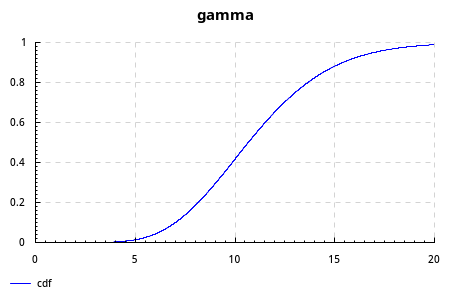

In [18]:
toRenderable $ 
    let xs = [0,0.01..20]
        vs = [(x, cumulative stakeDistr x) | x <- xs]
    in do 
        layout_title .= "gamma"
        plot (line "cdf" [vs])

## Committee selection
https://peras.cardano-scaling.org/docs/reports/tech-report-2#sortition-like-voting

## Transaction size

In [19]:
txDistr :: LognormalDistribution
txDistr = lognormalDistr 6.83 1.13

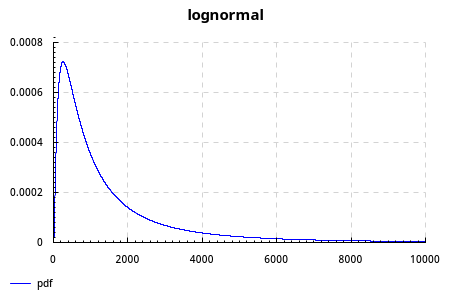

In [20]:
toRenderable $ 
    let xs = [1..10000]
        vs = [(x, density txDistr x) | x <- xs]
    in do 
        layout_title .= "lognormal"
        plot (line "pdf" [vs])

## Validate EB
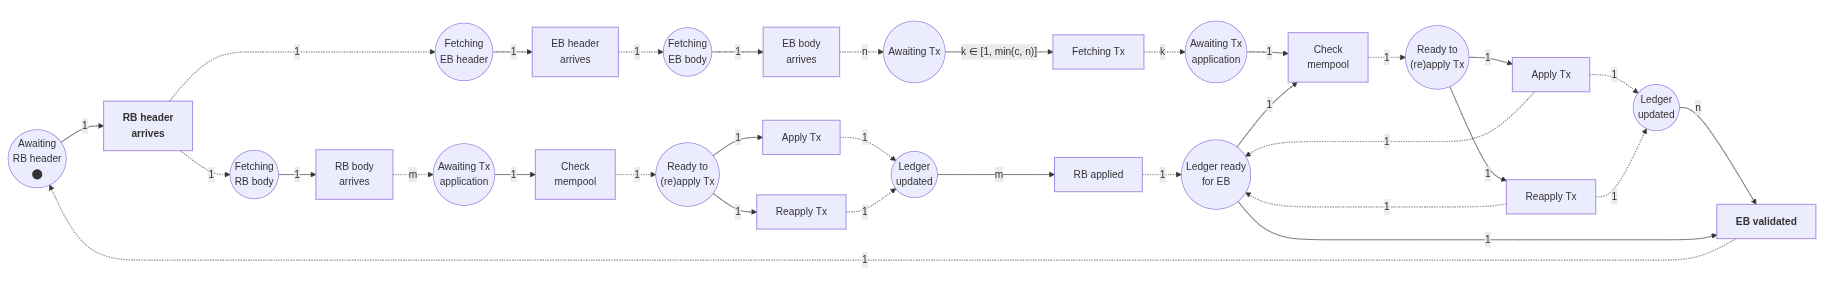

DeltaQ model produced by the topology checker tool:

distance distribution in hops ([(0.0, 0.0), (1.0, 1909.0), (2.0, 3867.0), (3.0, 2826.0), (4.0, 1068.0), (5.0, 214.0), (6.0, 16.0), (7.0, 0.0)])

#### this is the main result expression
```
gossip := (near ->- (CDF[(0, 1)] 0.022773398<>0.9772266 near ->- (CDF[(0, 1)] 0.022773398<>0.9772266 near ->- (CDF[(0, 1)] 0.022773398<>0.9772266 near ->- (CDF[(0, 1)] 0.58243084<>0.41756916 near))))) ->- (CDF[(0, 1)] 0.7476325<>0.2523675 far ->- CDF[(0, 1)])
```
#### gossip is built on these outcomes that should contain send and receive actions
```
near := near_send
far := far_send
```
#### these are the extracted latencies from the topology
```
near_send := CDF[(0.0643, 0.33075), (3.8168, 0.7382), (18.0988, 0.88127), (26.712, 0.96207), (37.2126, 0.98242), (48.229, 0.98844), (54.2403, 0.99163), (67.2503, 0.99423), (73.0689, 0.99682), (81.6974, 1)]
far_send := CDF[(78.737, 0.0023), (83.8947, 0.02122), (134.1927, 0.09285), (185.3148, 0.17255), (231.64439, 0.24732), (276.2988, 0.37204), (318.3721, 0.68758), (363.1637, 0.96066), (457.63721, 0.99691), (529.08582, 1)]
```

In [21]:
hopCount = [(1, 1909), (2, 3867), (3, 2826), (4, 1068), (5, 214), (6, 16)]
-- hopCount = [(1, 6), (2, 5), (3, 1)]

In [22]:
blendedDelay :: BlockSize -> DQ
blendedDelay b = choices $ map (\(n , p) -> (p, hops n b)) hopCount

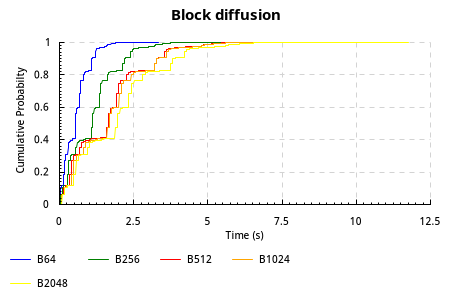

In [23]:
toRenderable $ plotCDFs "Block diffusion" $ zip (map show blockSizes) (map blendedDelay blockSizes)

In [24]:
emitRBHeader :: DQ
emitRBHeader = blendedDelay B64

fetchingRBBody :: DQ
fetchingRBBody = blendedDelay B1024

In [25]:
fetchingEBHeader :: DQ
fetchingEBHeader = blendedDelay B64

fetchingEBBody :: DQ
fetchingEBBody = blendedDelay B2048

fetchingEB :: DQ
fetchingEB = fetchingEBHeader .>>. fetchingEBBody

TODO:

In [26]:
fetchingTxs :: DQ
fetchingTxs = wait 1

checkMempool :: DQ
checkMempool = wait 1

applyTx :: DQ
applyTx = wait 1

reapplyTx :: DQ
reapplyTx = wait 1

In [27]:
checkMempoolAndApply :: DQ
checkMempoolAndApply = checkMempool .>>. (applyTx .\/. reapplyTx)

In [28]:
validatedEB :: DQ
validatedEB = 
         (fetchingEB .>>. fetchingTxs .>>. checkMempoolAndApply) 
    ./\. (fetchingRBBody .>>. checkMempoolAndApply .>>. checkMempoolAndApply)

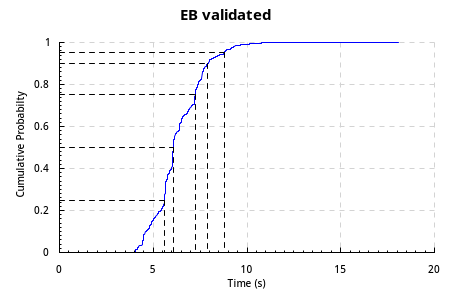

In [29]:
toRenderable $ plotCDFWithQuantiles "EB validated" [0.25, 0.5, 0.75, 0.9, 0.95] validatedEB

## Updating the memory pool

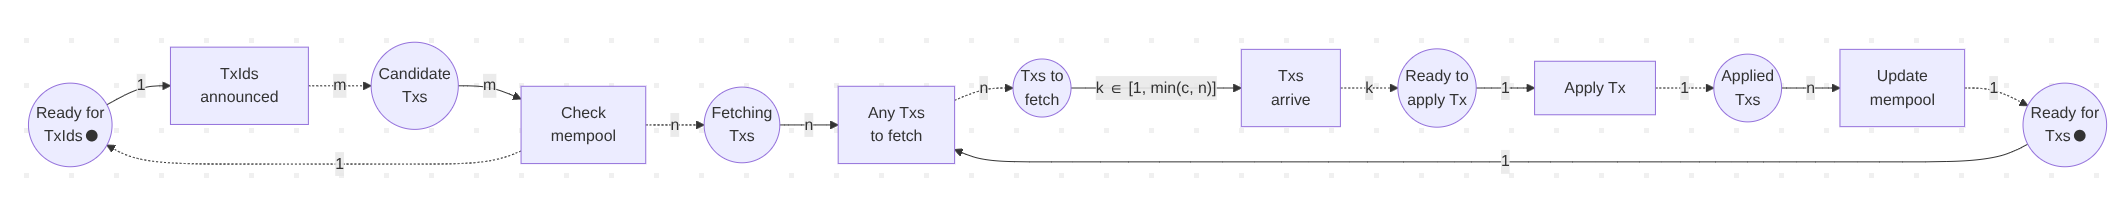

## Tallying and certifying votes

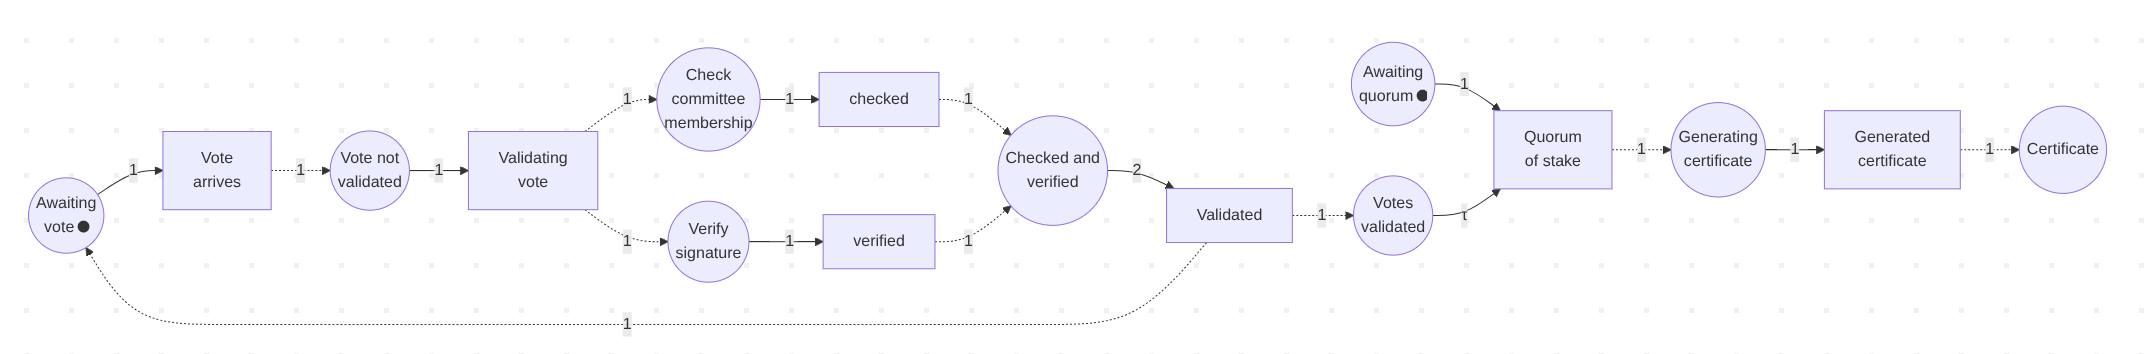

## Questions to ask

* There's an RB with an EB. What is the probablity that the next RB has a certificate for the EB?
* Probability to be in the voting committee, resp. probability that votes get delivered on-time. What are the preconditions? What are the different scenarios to be considered? Probability of a quorum?
* Will there be a fork of the Praos chain, if the slot leader has not received the EB corresponding to a certificate in an RB that the slot leader is supposed to extend? EB diffusion would affect the Praos chain behaviour?
* What is the probability that a transaction is not known, i.e., needs to be fetched explicitly? Model tx diffusion


## Probability of certificate in next RB

Assumption: all nodes are honest

$RB$ ist the current ranking block and $RB'$ extends $RB$. Assume $RB$ has an $EB$ attached.

$
A = \{ \text{Cert in RB'} \neq \emptyset \}    \\
P[A] = ?
$

### [Step 1: Block Production](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-1-block-production)



### [Step 2: EB Distribution](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-2-eb-distribution)

### [Step 3: Committee Validation](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-3-committee-validation)

1. The RB header arrived within $L_\text{hdr}$,

In [30]:
pHeaderOnTime :: Probability DQ
pHeaderOnTime = successWithin emitRBHeader lHdr 

In [31]:
fromRational pHeaderOnTime

0.8252825927311525

2. It has **not** detected any equivocating RB header for the same slot,
3. It finished validating the EB before $3 \times L_\text{hdr} + L_\text{vote}$
   slots after the EB slot,

In [32]:
pValidating :: Probability DQ
pValidating = successWithin validatedEB (3*lHdr + lVote) 

In [33]:
fromRational pValidating

0.6917702823404569

4. The EB is the one announced by the latest RB in the voter's current chain,
5. The EB's transactions form a **valid** extension of the RB that announced it,
6. For non-persistent voters, it is eligible to vote based on sortition using
   the announcing RB's slot number as the election identifier,
7. The EB contains at least one transaction (i.e., is not empty), as specified
   in the [formal specification][leios-formal-spec-empty-eb].

### [Step 4: Certification](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-4-certification)




### [Step 5: Chain Inclusion](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-5-chain-inclusion)


In [34]:
-- waitingSlots

### All steps

In [35]:
allSteps :: DQ
allSteps = emitRBHeader .>>. validatedEB

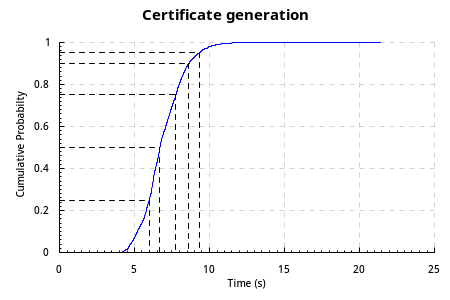

In [36]:
toRenderable $ plotCDFWithQuantiles "Certificate generation" [0.25, 0.5, 0.75, 0.9, 0.95] allSteps

In [37]:
-- pCertificate :: Probability DQ
-- pCertificate = successWithin validatedEB (3*lHdr + lVote)

u :: DQ
u = uniform 0 1

cumsum :: Num a => [a] -> [a]
cumsum = foldl (\acc x -> acc ++ [x + if null acc then 0 else last acc]) []

f :: Rational -> Rational
f x = realToFrac $ -(log (fromRational x) / lambda)

exponential :: DQ
exponential = choices $ map (\x -> (x, wait $ f x)) [0, 0.01 .. 1]

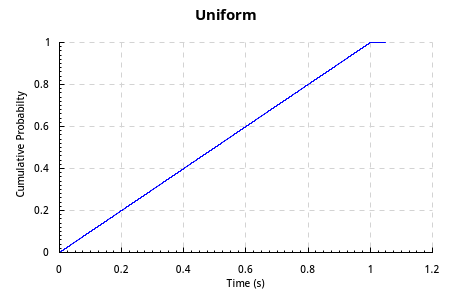

In [38]:
toRenderable $ plotCDF "Uniform" u

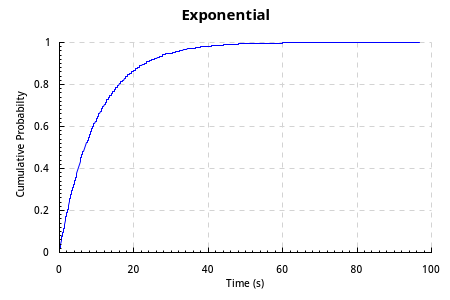

In [39]:
toRenderable $ plotCDF "Exponential" exponential